Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import f1_score # better metric 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import SVC,LinearSVC
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import string 
import warnings 
warnings.filterwarnings('ignore')
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = STOP_WORDS
nlp = spacy.load('en_core_web_sm')
from sklearn.metrics import accuracy_score,log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
data_path="/content/drive/MyDrive/Colab Notebooks/data/Personalitydataset/mbti_1.csv"
df=pd.read_csv(data_path)
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


Pre-Processing 

In [3]:

def preprocess_text(df, remove_special=True):
    texts = df['posts'].copy()
    labels = df['type'].copy()

    #Remove links 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'https?:\/\/.*?[\s+]', '', x.replace("|"," ") + " "))
    
    #Keep the End Of Sentence characters
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\.', ' EOSTokenDot ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'\?', ' EOSTokenQuest ', x + " "))
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'!', ' EOSTokenExs ', x + " "))
    
    #Strip Punctation
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[\.+]', ".",x))

    #Remove multiple fullstops
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove Non-words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'[^a-zA-Z\s]','',x))

    #Convert posts to lowercase
    df["posts"] = df["posts"].apply(lambda x: x.lower())

    #Remove multiple letter repeating words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'([a-z])\1{2,}[\s|\w]*','',x)) 

    #Remove very short or long words
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{0,3})?\b','',x)) 
    df["posts"] = df["posts"].apply(lambda x: re.sub(r'(\b\w{30,1000})?\b','',x))

    #Remove MBTI Personality Words - crutial in order to get valid model accuracy estimation for unseen data. 
    if remove_special:
        pers_types = ['INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ','ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']
        pers_types = [p.lower() for p in pers_types]
        p = re.compile("(" + "|".join(pers_types) + ")")
    
    return df
def preprocess(train):

    doc = nlp(train, disable = ['ner', 'parser'])

    lemmas = [token.lemma_ for token in doc]

    a_lemma = [lemma for lemma in lemmas if lemma.isalpha() and lemma not in stopwords ]
    return ' ' .join(a_lemma)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
# Making use of the clean_data function
all_data=df
all_data['posts2']= all_data['posts'].apply(preprocess)
all_data['posts3']=[''.join(post) for post in all_data['posts2']]

In [5]:
all_data.head()

,type,posts,posts2,posts3
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,intj moment sportscent play life change experi...,intj moment sportscent play life change experi...
1,ENTP,'I'm finding the lack of me in these posts ver...,find lack post bore position example girlfrien...,find lack post bore position example girlfrien...
2,INTP,'Good one _____ https://www.youtube.com/wat...,good course know blessing absolutely positive ...,good course know blessing absolutely positive ...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",dear INTP enjoy conversation day Esoteric gabb...,dear INTP enjoy conversation day Esoteric gabb...
4,ENTJ,'You're fired.|||That's another silly misconce...,silly misconception approach logically key unl...,silly misconception approach logically key unl...


In [6]:
#Total number of posts for each personality type
personality_types = all_data['type'].value_counts()

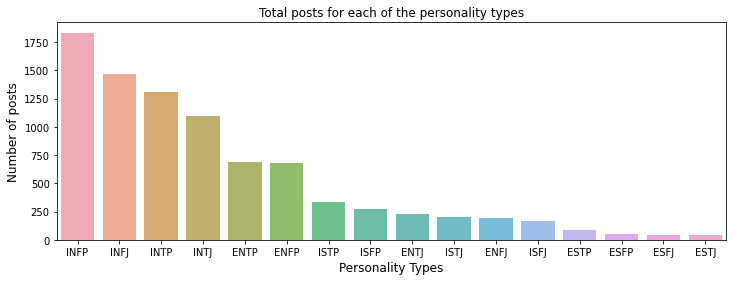

In [7]:
#Check the ditribution of MBTI personality types
plt.figure(figsize=(12,4))
sns.barplot(personality_types.index, personality_types.values, alpha=0.8)
plt.ylabel('Number of posts', fontsize=12)
plt.xlabel('Personality Types', fontsize=12)
plt.title('Total posts for each of the personality types')
plt.show()

Splitting into train and test

In [8]:
# splitting data to training and testing data set...
from sklearn.model_selection import train_test_split
def splitting(file1,testratio):
  p={}
  for k in file1:
    if(k!="type"):
      p.update({k:file1[k]})
  X = pd.DataFrame(p)
  # X=X.values
  Y= file1["type"]
  X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = testratio,stratify=Y,random_state=42)
  return  X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = splitting (all_data,0.3)

In [9]:
df_train=pd.concat([y_train,X_train],axis=1)
df_train.head()
df_test=pd.concat([y_test,X_test],axis=1)
df_test.head()

,type,posts,posts2,posts3
4511,ENTJ,"'Thanks to all you guys, I really thought I wa...",thank guy think feel good understand struggle ...,thank guy think feel good understand struggle ...
744,ISTP,'Haha! That must have been it... I need to com...,haha need come chat want discuss type ball mis...,haha need come chat want discuss type ball mis...
7533,INTP,'When I was younger I was more daring. I lost ...,young daring lose license speed violation sing...,young daring lose license speed violation sing...
876,INFP,'i have not found love. i have high standards....,find love high depend like friendly try know b...,find love high depend like friendly try know b...
701,INFJ,'Which fictional character(s) do you relate to...,fictional relate character consider ENFPs sure...,fictional relate character consider ENFPs sure...


In [10]:
all_data_pre=pd.concat([df_train,df_test])

Vectorizing

In [11]:
# Create the transform 
vectorizer = TfidfVectorizer(ngram_range=(1,1), analyzer='word' ,stop_words='english')
all_data_post = vectorizer.fit_transform(all_data_pre['posts3'])

In [12]:
# Demerging the train and test dataframe from the all_data dataframe. 
len_slice = df_train.shape[0] 
# Slice train data frame from all_data dataframe
train = all_data_post[:len_slice]
# Slice test data frame from all_data dataframe
test = all_data_post[len_slice:]
# Target variable
y = df_train['type'] 

In [13]:
print(train)

  (0, 61280)	0.04084416260570758
  (0, 52134)	0.048420814629485824
  (0, 42956)	0.03267397213770006
  (0, 65052)	0.04744389524794425
  (0, 14690)	0.04576154988820494
  (0, 70856)	0.019164685557592938
  (0, 12696)	0.012276240458414054
  (0, 24025)	0.01683069304859509
  (0, 16324)	0.02419600858019097
  (0, 46538)	0.05309041729598733
  (0, 72487)	0.06605617420923554
  (0, 32816)	0.042507473887374386
  (0, 43057)	0.03055612218119828
  (0, 67300)	0.049053313444271295
  (0, 22797)	0.05055907835020824
  (0, 66328)	0.02842193997556729
  (0, 46482)	0.03861053925919481
  (0, 16904)	0.03386639088393893
  (0, 48639)	0.02796341990577525
  (0, 20175)	0.03117451819229288
  (0, 54297)	0.06740611853941801
  (0, 74333)	0.02458229868302772
  (0, 29655)	0.01707632166986868
  (0, 73414)	0.050095891430924876
  (0, 9603)	0.05201520431723249
  :	:
  (6071, 40011)	0.01675402596048157
  (6071, 60334)	0.029622037857783497
  (6071, 58195)	0.02716299413652457
  (6071, 37826)	0.10286583746000502
  (6071, 14388)	0.0

In [14]:
print(y)

3328    INFP
5570    INFJ
2108    INFP
5991    ESFJ
2337    INTJ
        ... 
7871    INFP
1158    INTJ
5581    ENTJ
8629    INTP
7403    ESFJ
Name: type, Length: 6072, dtype: object


In [15]:
# Applying the encoding to the target variable y
mind = y.apply(lambda x: 0 if x[0] == 'I' else 1)
energy = y.apply(lambda x: 0 if x[1] == 'S' else 1)
nature = y.apply(lambda x: 0 if x[2] == 'F' else 1)
tactics = y.apply(lambda x: 0 if x[3] == 'P' else 1)

decoding the target variable 

In [16]:
def conversion(data):
  val=data.values
  di=[]
  for k in val:
    se=""
    if(k[0]==0):
      se+="I"
    else:
      se+='E'
    if(k[1]==0):
      se+="S"
    else:
      se+='N'
    if(k[2]==0):
      se+="F"
    else:
      se+='T'
    if(k[3]==0):
      se+="P"
    else:
      se+='J'
    di.append(se)
  return di

Accuracies and reports

In [17]:
def reports(train,train_pred,test,test_pred):
  print("On Training datasets")
  print("Accuracy:",accuracy_score(train, train_pred))
  print('classification report \n',classification_report(train,train_pred))
  print("Confusion Matrix \n ",confusion_matrix(train,train_pred))

  print("On Test datasets")
  print("Accuracy:",accuracy_score(test, test_pred))
  print('classification report \n',classification_report(test,test_pred))
  print("Confusion Matrix \n ",confusion_matrix(test,test_pred))

# Models

Logistic Regression

In [18]:
def Logistic_Regression(train_df, test_df, cate_df):
    # Instantiating the object
    classifier = LogisticRegression(random_state=0,class_weight='balanced')
    classifier.fit(train_df, cate_df)
    # Predictions on the train dataframe
    prediction_train = pd.DataFrame(classifier.predict(train_df))
    # Predictions on the test dataframe
    prediction_test = pd.DataFrame(classifier.predict(test_df))
    return prediction_train,prediction_test

In [19]:
# Applying the Logistic_Regression function on the category data
M_train_prediction,M_test_prediction = Logistic_Regression(train, test, mind)
E_train_prediction,E_test_prediction = Logistic_Regression(train, test, energy)
N_train_prediction,N_test_prediction = Logistic_Regression(train, test, nature)
T_train_prediction,T_test_prediction = Logistic_Regression(train, test, tactics)

In [20]:
# Concatenating our predictions into one dataframe
sub_train_1 = pd.concat([M_train_prediction,E_train_prediction,N_train_prediction,T_train_prediction], axis=1)
sub_test_1 = pd.concat([M_test_prediction,E_test_prediction,N_test_prediction,T_test_prediction], axis=1)

In [21]:
sub_train_1.columns = [ 'mind', 'energy', 'nature', 'tactics']
sub_test_1.columns = [ 'mind', 'energy', 'nature', 'tactics']

In [22]:
sub_train_1.head()

,mind,energy,nature,tactics
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,1,0,1,1
4,0,1,1,1


In [23]:
logistic_val=conversion(sub_train_1)
logistic_test=conversion(sub_test_1)
reports(df_train["type"],logistic_val,df_test["type"],logistic_test)

On Training datasets
Accuracy: 0.7577404479578392
classification report 
               precision    recall  f1-score   support

        ENFJ       0.36      0.56      0.44       133
        ENFP       0.77      0.70      0.73       472
        ENTJ       0.53      0.69      0.60       162
        ENTP       0.77      0.79      0.78       479
        ESFJ       0.26      0.38      0.31        29
        ESFP       0.16      0.41      0.23        34
        ESTJ       0.25      0.59      0.35        27
        ESTP       0.36      0.76      0.49        62
        INFJ       0.86      0.74      0.80      1029
        INFP       0.89      0.81      0.85      1282
        INTJ       0.81      0.78      0.80       764
        INTP       0.86      0.79      0.82       913
        ISFJ       0.54      0.71      0.61       116
        ISFP       0.65      0.69      0.67       190
        ISTJ       0.58      0.74      0.65       144
        ISTP       0.74      0.77      0.75       236

    ac

Random_forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
def Randomforest_Classifier(train_df, test_df, cate_df):
  rfc = RandomForestClassifier(n_estimators=30, min_samples_leaf=50, oob_score=True, n_jobs= -1, random_state=123)
  rfc.fit(train_df, cate_df)
  # Predictions on the train dataframe
  prediction_train = pd.DataFrame( rfc.predict(train_df))
    # Predictions on the test dataframe
  prediction_test = pd.DataFrame( rfc.predict(test_df))
  return prediction_train,prediction_test

In [25]:
# Applying the Logistic_Regression function on the mind category
M_train_prediction3,M_test_prediction3 =Randomforest_Classifier(train, test, mind)
E_train_prediction3,E_test_prediction3 =Randomforest_Classifier(train, test, energy)
N_train_prediction3,N_test_prediction3 =Randomforest_Classifier(train, test, nature)
T_train_prediction3,T_test_prediction3 =Randomforest_Classifier(train, test, tactics)

In [26]:
# Concatenating our predictions into one dataframe
sub_train_3= pd.concat([M_train_prediction3,E_train_prediction3,N_train_prediction3,T_train_prediction3], axis=1)
sub_test_3= pd.concat([M_test_prediction3,E_test_prediction3,N_test_prediction3,T_test_prediction3], axis=1)

In [27]:
rf_val=conversion(sub_train_3)
rf_test=conversion(sub_test_3)
reports(df_train["type"],rf_val,df_test["type"],rf_test)

On Training datasets
Accuracy: 0.30154808959156787
classification report 
               precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00       133
        ENFP       0.00      0.00      0.00       472
        ENTJ       0.00      0.00      0.00       162
        ENTP       0.00      0.00      0.00       479
        ESFJ       0.00      0.00      0.00        29
        ESFP       0.00      0.00      0.00        34
        ESTJ       0.00      0.00      0.00        27
        ESTP       0.00      0.00      0.00        62
        INFJ       0.55      0.01      0.01      1029
        INFP       0.28      0.95      0.43      1282
        INTJ       0.62      0.01      0.02       764
        INTP       0.35      0.65      0.46       913
        ISFJ       0.00      0.00      0.00       116
        ISFP       0.00      0.00      0.00       190
        ISTJ       0.00      0.00      0.00       144
        ISTP       0.00      0.00      0.00       236

    a

LightGBM

In [28]:
import lightgbm as lgb
def lgbm_classifier(train_df, test_df, cate_df):
  m1 = lgb.LGBMClassifier(n_estimators=100, min_samples_leaf=50, oob_score=True, n_jobs= -1, random_state=42)
  m1.fit(train_df,cate_df)
  # Predictions on the train dataframe
  prediction_train = pd.DataFrame(m1.predict(train_df))
    # Predictions on the test dataframe
  prediction_test = pd.DataFrame(m1.predict(test_df))
  return prediction_train,prediction_test

In [29]:
# Applying the Logistic_Regression function on the mind category
M_train_prediction4,M_test_prediction4 =lgbm_classifier(train, test, mind)
E_train_prediction4,E_test_prediction4 =lgbm_classifier(train, test, energy)
N_train_prediction4,N_test_prediction4 =lgbm_classifier(train, test, nature)
T_train_prediction4,T_test_prediction4 =lgbm_classifier(train, test, tactics)

In [30]:
# Concatenating our predictions into one dataframe
sub_train_4= pd.concat([M_train_prediction4,E_train_prediction4,N_train_prediction4,T_train_prediction4], axis=1)
sub_test_4= pd.concat([M_test_prediction4,E_test_prediction4,N_test_prediction4,T_test_prediction4], axis=1)

In [31]:
lg_val=conversion(sub_train_4)
lg_test=conversion(sub_test_4)
reports(df_train["type"],lg_val,df_test["type"],lg_test)

On Training datasets
Accuracy: 0.9881422924901185
classification report 
               precision    recall  f1-score   support

        ENFJ       0.97      0.98      0.98       133
        ENFP       0.99      0.99      0.99       472
        ENTJ       0.99      0.98      0.98       162
        ENTP       0.99      0.99      0.99       479
        ESFJ       0.90      0.90      0.90        29
        ESFP       0.94      0.94      0.94        34
        ESTJ       0.96      0.93      0.94        27
        ESTP       0.97      0.98      0.98        62
        INFJ       1.00      0.98      0.99      1029
        INFP       0.98      1.00      0.99      1282
        INTJ       0.99      0.99      0.99       764
        INTP       0.99      0.98      0.99       913
        ISFJ       1.00      1.00      1.00       116
        ISFP       0.99      1.00      0.99       190
        ISTJ       1.00      0.97      0.99       144
        ISTP       0.98      0.99      0.99       236

    ac

Multinomial Naive Bayes

In [32]:
from sklearn.naive_bayes import MultinomialNB
def multinomial(train_df, test_df, cate_df):
  gnb=MultinomialNB()
  gnb.fit(train_df,cate_df)
  # Predictions on the train dataframe
  prediction_train = pd.DataFrame(gnb.predict(train_df))
    # Predictions on the test dataframe
  prediction_test = pd.DataFrame(gnb.predict(test_df))
  return prediction_train,prediction_test

In [33]:
# Applying the Logistic_Regression function on the mind category
M_train_prediction5,M_test_prediction5 =multinomial(train, test, mind)
E_train_prediction5,E_test_prediction5 =multinomial(train, test, energy)
N_train_prediction5,N_test_prediction5 =multinomial(train, test, nature)
T_train_prediction5,T_test_prediction5 =multinomial(train, test, tactics)

In [34]:
# Concatenating our predictions into one dataframe
sub_train_5= pd.concat([M_train_prediction5,E_train_prediction5,N_train_prediction5,T_train_prediction5], axis=1)
sub_test_5= pd.concat([M_test_prediction5,E_test_prediction5,N_test_prediction5,T_test_prediction5], axis=1)

In [35]:
gnb_val=conversion(sub_train_5)
gnb_test=conversion(sub_test_5)
reports(df_train["type"],gnb_val,df_test["type"],gnb_test)

On Training datasets
Accuracy: 0.25049407114624506
classification report 
               precision    recall  f1-score   support

        ENFJ       0.00      0.00      0.00       133
        ENFP       0.00      0.00      0.00       472
        ENTJ       0.00      0.00      0.00       162
        ENTP       0.00      0.00      0.00       479
        ESFJ       0.00      0.00      0.00        29
        ESFP       0.00      0.00      0.00        34
        ESTJ       0.00      0.00      0.00        27
        ESTP       0.00      0.00      0.00        62
        INFJ       0.00      0.00      0.00      1029
        INFP       0.24      1.00      0.38      1282
        INTJ       0.00      0.00      0.00       764
        INTP       0.38      0.27      0.31       913
        ISFJ       0.00      0.00      0.00       116
        ISFP       0.00      0.00      0.00       190
        ISTJ       0.00      0.00      0.00       144
        ISTP       0.00      0.00      0.00       236

    a